In [1]:
cd ../../

/workspaces/research/motor-decoding


In [2]:
import json
import sys
from collections import Counter
from itertools import cycle
from pathlib import Path

import dabest
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne_bids.read import read_raw_bids
from mne_bids import BIDSPath
from rerf.rerfClassifier import rerfClassifier
from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from tqdm import tqdm

from mtsmorf.io.read import read_dataset, read_label, read_trial, get_trial_info
from mtsmorf.io.utils import NumpyEncoder
from mtsmorf.io.experiments import run_classifier_comparison, cv_fit

from mtsmorf.move_exp.plotting import (
    plot_signals,
    plot_roc_multiclass_cv,
    plot_feature_importances,
    plot_cv_indices
)

# plt.style.use(['science', 'ieee', 'no-latex'])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# bids_root = Path("/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/data/efri/")

tmin, tmax = (-0.75, 1.25)

bids_root = Path("/workspaces/research/mnt/data/efri")
derivatives_path = (
    bids_root / "derivatives" / "preprocessed" / f"tmin={tmin}-tmax={tmax}" / "band-pass=1-1000Hz-downsample=500"
)

# subject identifiers
subject = "efri07"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".vhdr", root=bids_root)

In [4]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

Out of 98 trials, there were 96 successful trials in /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 98 trials, there were 96 successful trials in /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.


## Band-pass filter (70-200 Hz)
- Standard band-pass filter on time-domain signal (70-200 Hz)
- Results: Classifier performance was at trivial levels on 5-fold stratified CV

In [5]:
# get preprocessed epochs data
fname = os.path.splitext(bids_path.basename)[0] + "-epo.fif"
fpath = derivatives_path / subject / fname
epochs = mne.read_epochs(fpath, proj=False, preload=True)

Reading /workspaces/research/mnt/data/efri/derivatives/preprocessed/tmin=-0.75-tmax=1.25/band-pass=1-1000Hz-downsample=500/efri07/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -750.00 ...    1248.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
96 matching events found
No baseline correction applied


In [6]:
cropped = epochs.copy()
cropped = cropped.crop(tmin=-0.5, tmax=1.0)

cropped.drop(unsuccessful_trial_inds)

cropped_data = cropped.get_data()
ntrials, nchs, nsteps = cropped_data.shape

Dropped 20 epochs: 3, 4, 9, 12, 13, 33, 38, 40, 41, 48, 51, 53, 68, 76, 81, 82, 86, 87, 90, 95


In [7]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = cropped_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


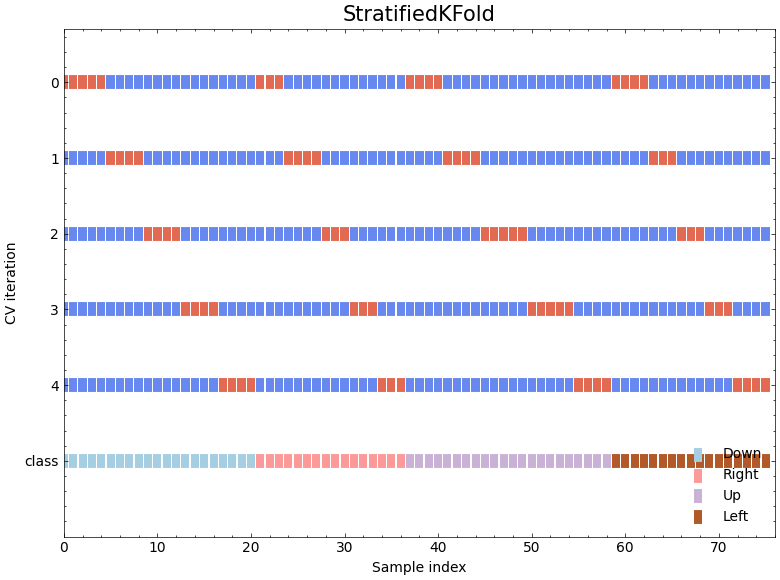

In [8]:
# Perform K-Fold cross validation
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
argsort_inds = np.argsort(y)
plot_cv_indices(cv, X[argsort_inds], y[argsort_inds], ax, n_splits, lw=10)
ax.legend(loc='lower right')
fig.tight_layout();

In [9]:
metrics = [
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

stratified_kf_scores = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


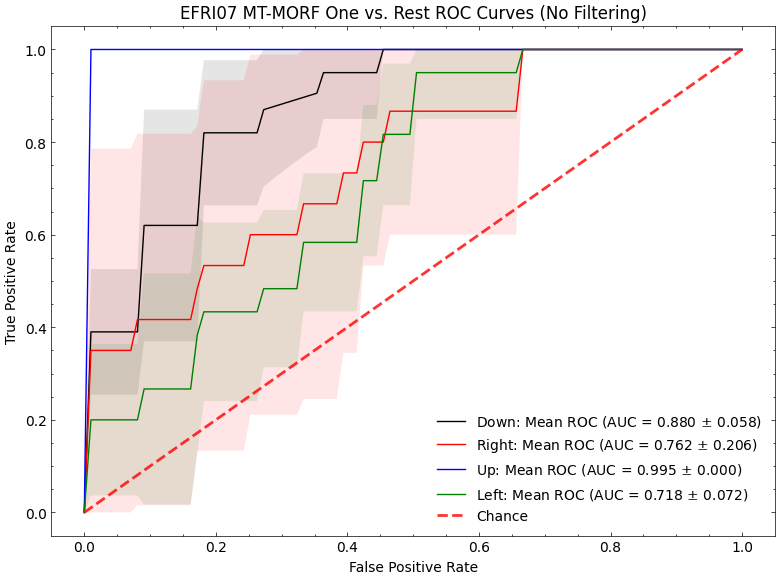

In [10]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores["test_predict_proba"],
    X,
    y,
    stratified_kf_scores["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (No Filtering)",
)
ax.legend(loc="lower right")
fig.tight_layout();

In [11]:
hi_gamma = epochs.filter(l_freq=70, h_freq=200)
hi_gamma.crop(tmin=-0.5, tmax=1.0)
hi_gamma = hi_gamma.drop(unsuccessful_trial_inds)

# get shape of data
hi_gamma_data = hi_gamma.get_data()
ntrials, nchs, nsteps = hi_gamma_data.shape
print(f'epochs_data.shape = {hi_gamma_data.shape}')

Setting up band-pass filter from 70 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 70.00
- Lower transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 61.25 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 95 samples (0.190 sec)

Dropped 20 epochs: 3, 4, 9, 12, 13, 33, 38, 40, 41, 48, 51, 53, 68, 76, 81, 82, 86, 87, 90, 95
epochs_data.shape = (76, 75, 751)


In [12]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = hi_gamma_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=nchs,
    image_width=nsteps,
)

stratified_kf_scores_filtered = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_filtered.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

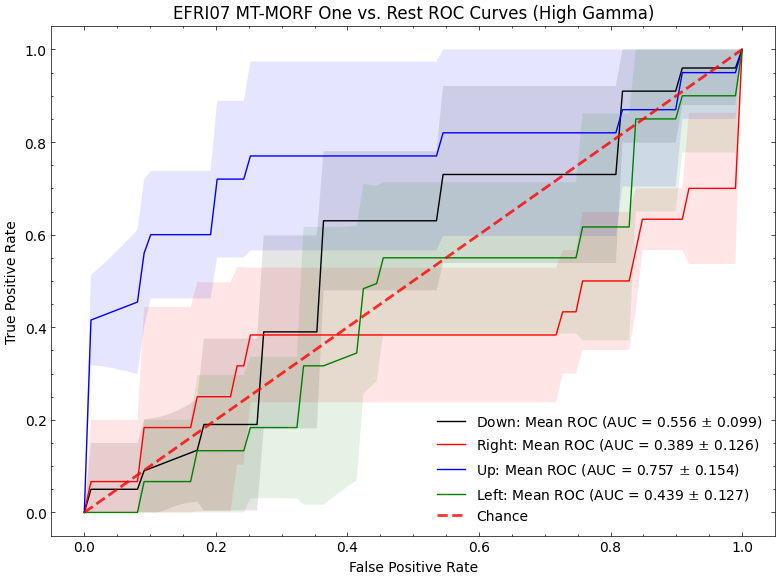

In [13]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_filtered["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_filtered["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (High Gamma)",
)
ax.legend(loc="lower right")
fig.tight_layout();

## Analyzing time-domain signal

In [5]:
# get preprocessed epochs data
fname = os.path.splitext(bids_path.basename)[0] + "-epo.fif"
fpath = derivatives_path / subject / fname

epochs = mne.read_epochs(fpath, preload=True)
epochs = epochs.drop(unsuccessful_trial_inds)

Reading /workspaces/research/mnt/data/efri/derivatives/preprocessed/tmin=-0.75-tmax=1.25/band-pass=1-1000Hz-downsample=500/efri07/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -750.00 ...    1248.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Dropped 20 epochs: 3, 4, 9, 12, 13, 33, 38, 40, 41, 48, 51, 53, 68, 76, 81, 82, 86, 87, 90, 95


In [15]:
drop_inds = {k : np.where(labels != k)[0] for k in np.unique(labels)}
label_names = {0: "Down", 1: "Right", 2: "Up", 3: "Left"}

In [16]:
epochs_by_direction = {}
for k, v in drop_inds.items():
    tmp = epochs.copy()
    tmp.drop(v)
    epochs_by_direction[k] = tmp

Dropped 55 epochs: 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 59, 61, 63, 64, 66, 69, 70, 73, 74
Dropped 60 epochs: 0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 15, 16, 17, 21, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38, 40, 41, 42, 43, 44, 45, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75
Dropped 54 epochs: 0, 1, 3, 5, 6, 8, 13, 14, 15, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 31, 32, 34, 35, 36, 38, 39, 41, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75
Dropped 59 epochs: 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 39, 40, 42, 43, 44, 46, 48, 49, 50, 51, 54, 57, 58, 60, 61, 62, 65, 66, 67, 68, 70, 71, 72, 73, 75


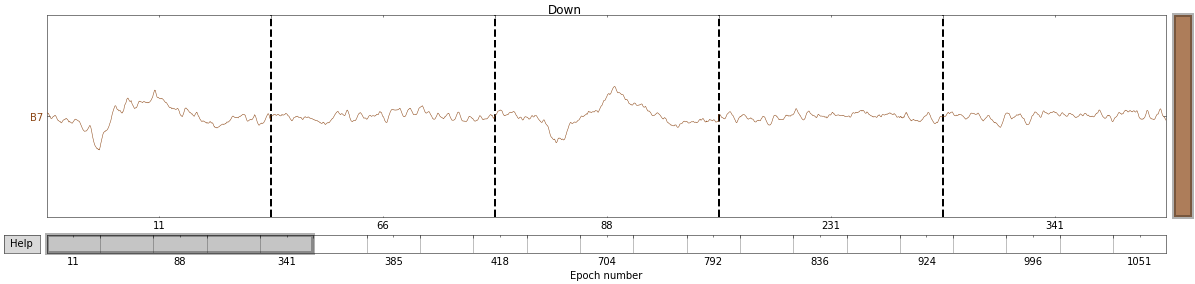

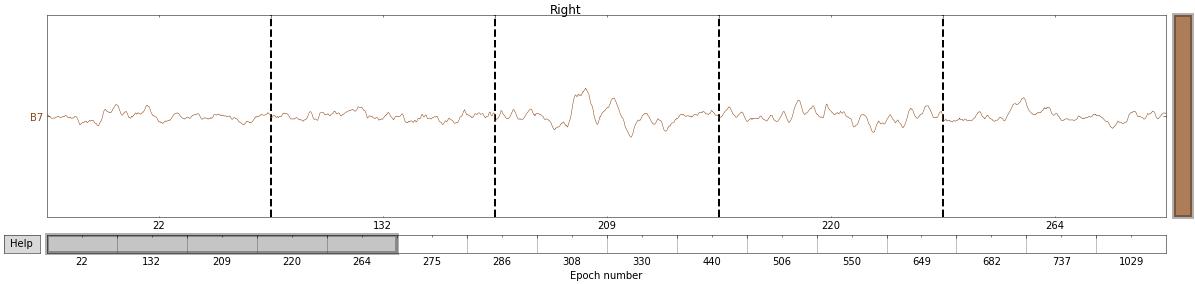

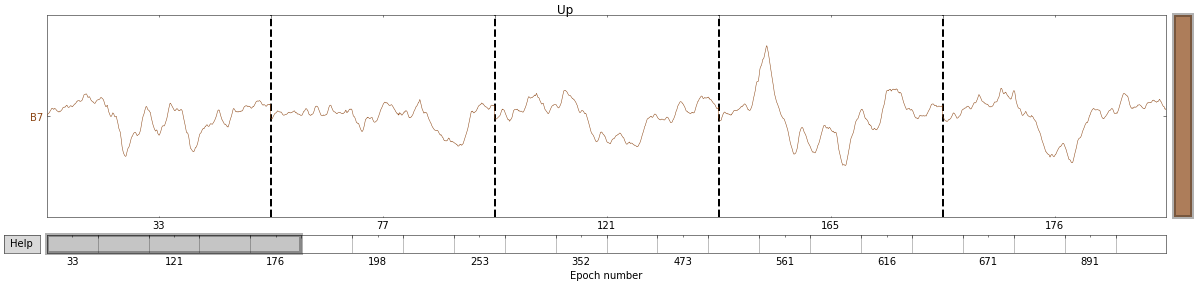

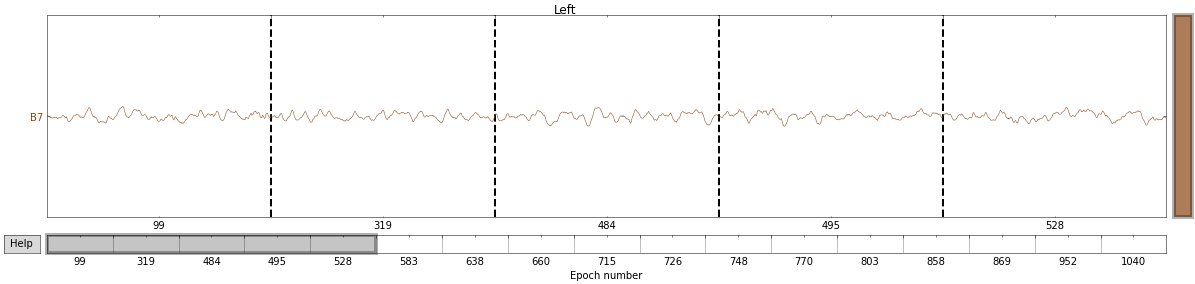

In [17]:
picks = ["B7"]
for k, ep in epochs_by_direction.items():
    fig = ep.plot(
        picks=picks,
        scalings=dict(seeg=1e3), 
        n_epochs=5,
        show=False,
        title=label_names[k],
    )
    fig.suptitle(label_names[k])
    fig.set_size_inches(18, 4, forward=True)
    plt.show()

Not setting metadata
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


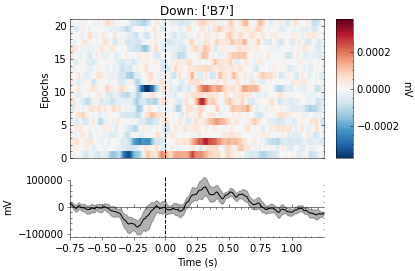

Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


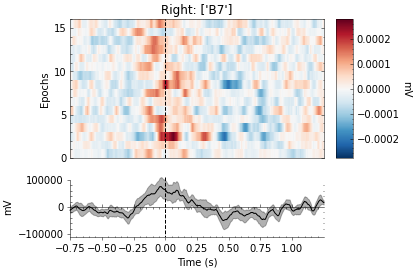

Not setting metadata
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


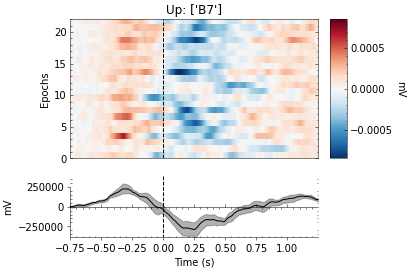

Not setting metadata
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


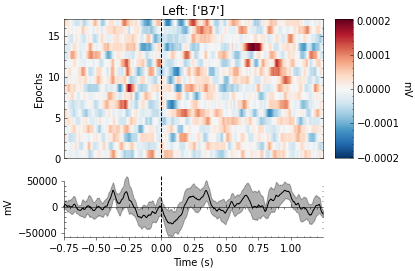

In [18]:
for i, (k, ep) in enumerate(epochs_by_direction.items()):
    ep.plot_image(
        picks=picks,
        scalings=dict(seeg=1e-6),
        title=f"{label_names[k]}: {picks}"
    );
plt.show()

## Computing Spectral Power for 70-200Hz
- Tried training only on median frequency bin (performs near chance)
- Likely because we dropped a great deal of spectral content

In [6]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

hi_gamma = power.data
hi_gamma.shape

Not setting metadata


(76, 75, 10, 334)

No baseline correction applied


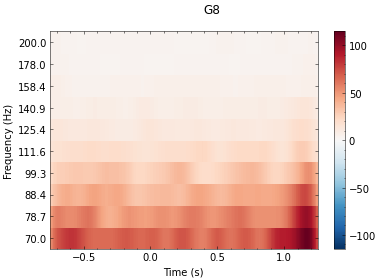

In [20]:
power.average().plot([0]);

## Average across freqs

In [7]:
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
inds = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, inds]

avg_freq_data.shape

(76, 75, 250)

In [8]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


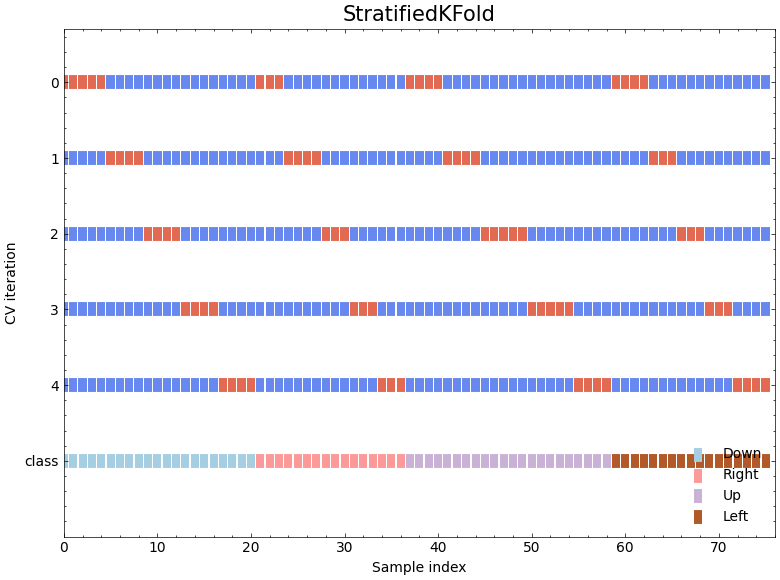

In [9]:
# Perform K-Fold cross validation
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=False)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
argsort_inds = np.argsort(y)
plot_cv_indices(cv, X[argsort_inds], y[argsort_inds], ax, n_splits, lw=10)
ax.legend(loc='lower right')
fig.tight_layout();

In [10]:
metrics = [
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_freq_avg = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_freq_avg.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

In [11]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_freq_avg["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_freq_avg["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


## Increase granularity of freq dimension

In [26]:
nfreqs = 30
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

Not setting metadata


No baseline correction applied


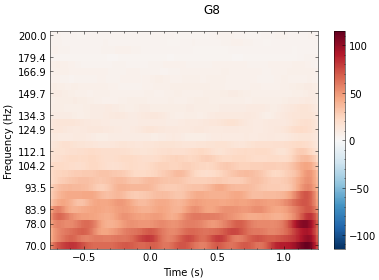

In [27]:
power.average().plot([0]);

In [28]:
hi_gamma = power.data
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_more_freq = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_more_freq.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

In [29]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_more_freq["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_more_freq["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

In [30]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "nfreqs=10": stratified_kf_scores_freq_avg["test_accuracy"],
    "nfreqs=30": stratified_kf_scores_more_freq["test_accuracy"],
})

my_data = dabest.load(df, idx=("nfreqs=10", "nfreqs=30"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="Accuracy Comparison in Number of Frequency Bins (70-200 Hz)");

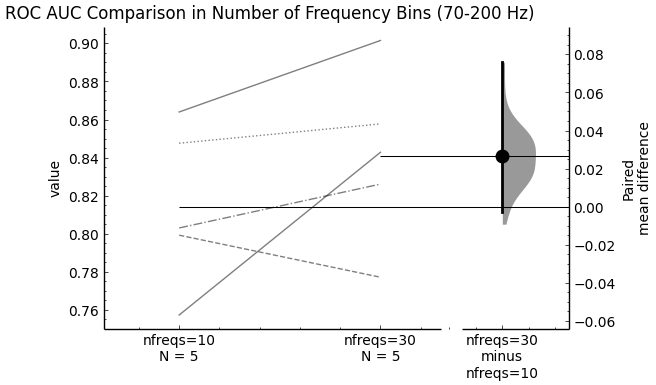

In [31]:
id_col = pd.Series(range(1, n_splits+1))

df = pd.DataFrame({
    "ID": id_col,
    "nfreqs=10": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "nfreqs=30": stratified_kf_scores_more_freq["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("nfreqs=10", "nfreqs=30"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

fig, ax = plt.subplots(dpi=100)

my_data.mean_diff.plot(ax=ax)
ax.set(title="ROC AUC Comparison in Number of Frequency Bins (70-200 Hz)");

## Apply Baseline

In [32]:
epochs = read_dataset(bids_path, kind='ieeg', tmin=-0.75, tmax=1.25, picks=None, event_key="Left Target")
epochs.load_data()

## Low-pass filter up to sfreq/2
fs = epochs.info["sfreq"]
epochs = epochs.filter(l_freq=0.5, h_freq=fs / 2 - 1)

## Downsample epochs to 500 Hz
resample_rate = 500
epochs = epochs.resample(resample_rate)
epochs.drop(unsuccessful_trial_inds)

Out of 98 trials, there were 96 successful trials in /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.


<Epochs |  76 events (all good), -0.75 - 1.248 sec, baseline off, ~43.6 MB, data loaded,
 '10006': 76>

### Time Domain

In [33]:
## Apply baseline
baseline = read_dataset(bids_path, kind='ieeg', tmin=0.0, tmax=2.0, picks=None, event_key="At Center")
baseline.load_data()

# Low-pass filter up to sfreq/2
fs = baseline.info["sfreq"]
baseline = baseline.filter(l_freq=0.5, h_freq=fs / 2 - 1)

# Downsample epochs to 500 Hz
resample_rate = 500
baseline = baseline.resample(resample_rate)
baseline.drop(unsuccessful_trial_inds)

# Subtract from epochs data
epochs_data = epochs.get_data()
baseline_data = baseline.get_data()

baseline_avg = np.mean(baseline_data, axis=0)  # Compute mean signal for baseline
baselined_epochs = epochs_data - baseline_avg  # Subtract mean signal to baseline

## Crop
times = epochs.times
inds = np.where((times >= -0.5) & (times <= 1.0))[0]
baselined_epochs = baselined_epochs[:, :, inds]

Out of 98 trials, there were 96 successful trials in /workspaces/research/mnt/data/efri/sub-efri07/ses-efri/ieeg/sub-efri07_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.


In [34]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = baselined_epochs[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

In [35]:
metrics = [
    'accuracy',
    'roc_auc_ovr',
]

## Fit model
mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=baselined_epochs.shape[1],
    image_width=baselined_epochs.shape[2],
)
stratified_kf_scores_baselined = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_baselined.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

In [36]:
## Plot results
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_baselined["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_baselined["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Epochs Baseline Corrected Time Domain Signal)",
)
ax.legend(loc="lower right")
fig.tight_layout();

In [37]:
id_col = pd.Series(range(1, n_splits+1))
fig, axs = plt.subplots(ncols=2, figsize=(22,6), dpi=200)
axs = axs.flatten()

## Accuracy Comparison
df = pd.DataFrame({
    "ID": id_col,
    "No Baseline": stratified_kf_scores_freq_avg["test_accuracy"],
    "Baseline": stratified_kf_scores_baselined["test_accuracy"],
})

my_data = dabest.load(df, idx=("No Baseline", "Baseline"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

my_data.mean_diff.plot(ax=axs[0])
axs[0].set(title="Accuracy Comparison in Baseline Correction of Time Domain Signal")

## ROC AUC Comparison
df = pd.DataFrame({
    "ID": id_col,
    "No Baseline": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "Baseline": stratified_kf_scores_baselined["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("No Baseline", "Baseline"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

my_data.mean_diff.plot(ax=axs[1])
axs[1].set(title="ROC AUC Comparison in Baseline Correction of Time Domain Signal");

### Freq Domain

In [12]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

baseline_power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                            return_itc=False, decim=3, n_jobs=1)

Not setting metadata
Not setting metadata


In [13]:
## Apply zscore baselining
power_data = power.data
baseline_power_data = baseline_power.data

baseline_power_avg = np.mean(baseline_power_data, axis=0)
baseline_power_std = np.std(baseline_power_data, axis=0)

baselined_power = (power_data - baseline_power_avg) / baseline_power_std

## Crop
times = power.times
inds = np.where((times >= -0.5) & (times <= 1.0))[0]
baselined_power = baselined_power[:, :, :, inds]

In [14]:
avg_freq_data_baseline = np.mean(baselined_power, axis=2)

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

## Create X, y data
X = avg_freq_data_baseline[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    'accuracy',
    'roc_auc_ovr',
]

## Fit model
mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data_baseline.shape[1],
    image_width=avg_freq_data_baseline.shape[2],
)
stratified_kf_scores_baseline = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)

## Plot results
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_baseline["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_baseline["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Epochs Baseline Corrected, Power Averaged over 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

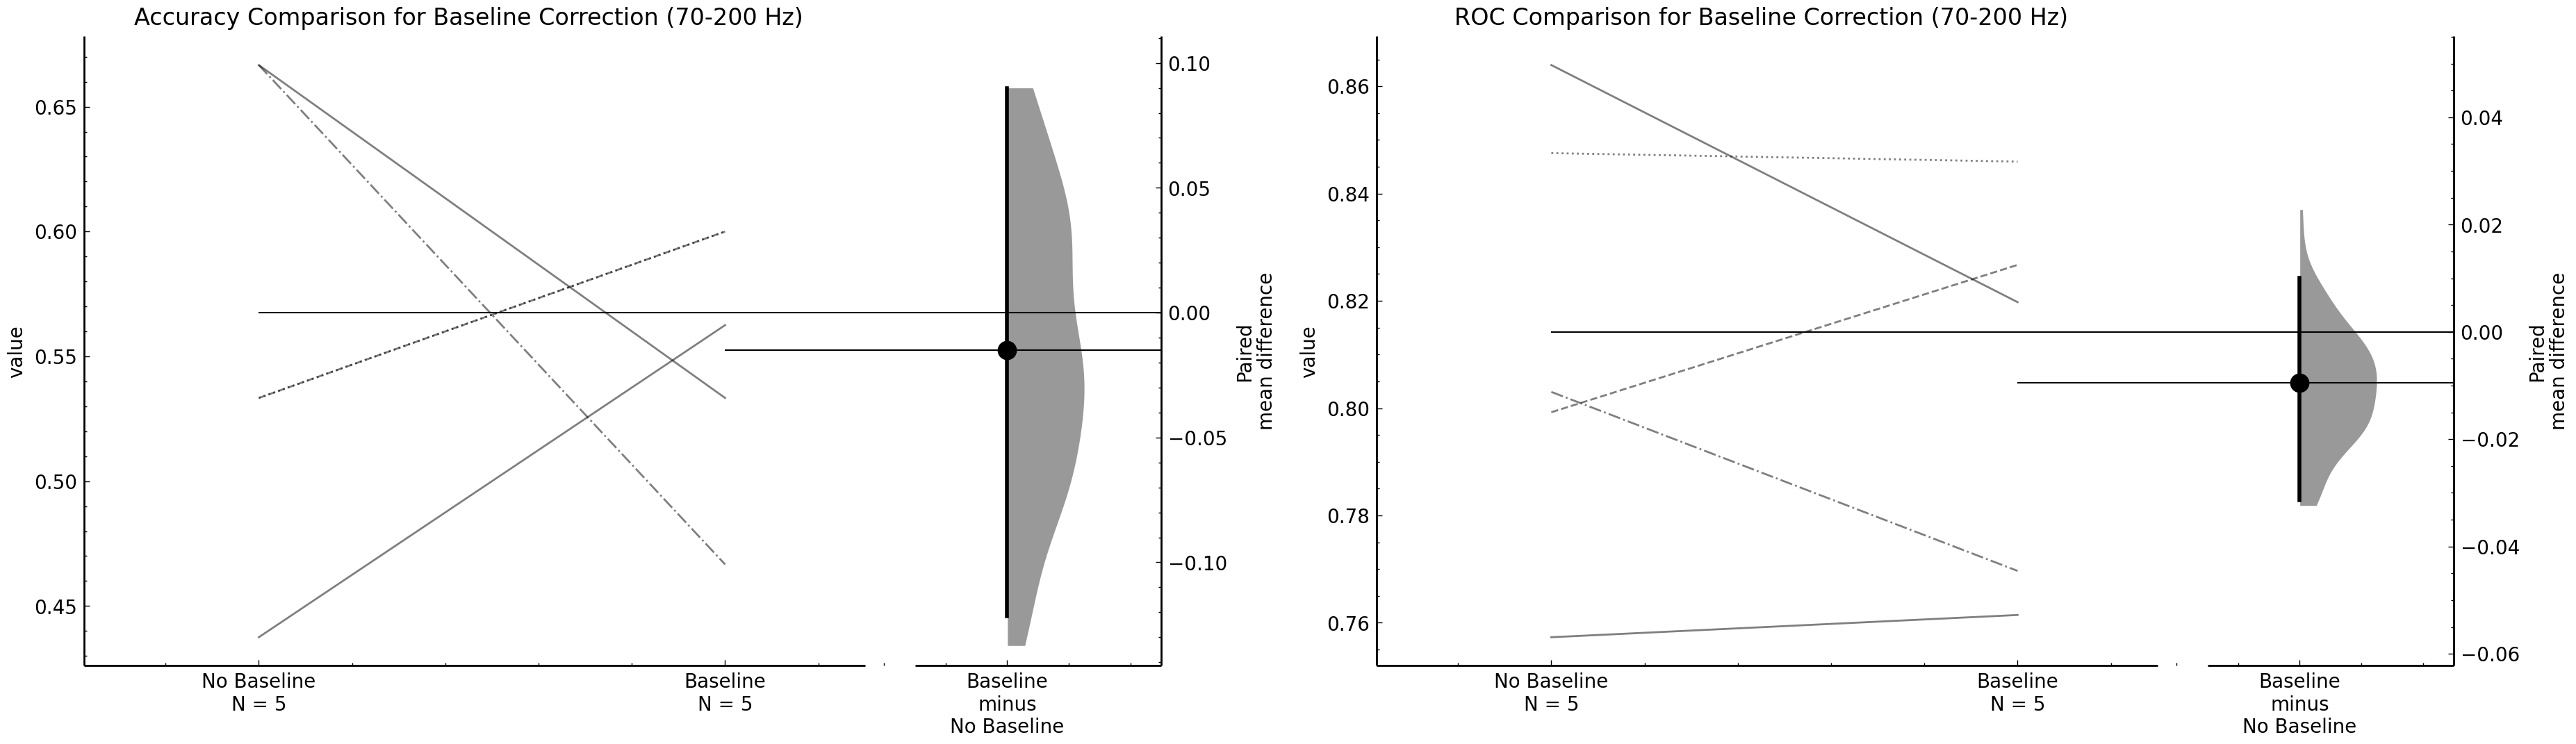

In [15]:
id_col = pd.Series(range(1, n_splits+1))

fig, axs = plt.subplots(ncols=2, figsize=(22, 6), dpi=200)
axs = axs.flatten()

## Accuracy Comparison between No Baselining and Baselining in Freq Domain
df = pd.DataFrame({
    "ID": id_col,
    "No Baseline": stratified_kf_scores_freq_avg["test_accuracy"],
    "Baseline": stratified_kf_scores_baseline["test_accuracy"],
})

my_data = dabest.load(df, idx=("No Baseline", "Baseline"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

my_data.mean_diff.plot(ax=axs[0])
axs[0].set(title="Accuracy Comparison for Baseline Correction (70-200 Hz)");

## ROC AUC Comparison between No Baselining and Baselining in Freq Domain
df = pd.DataFrame({
    "ID": id_col,
    "No Baseline": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "Baseline": stratified_kf_scores_baseline["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("No Baseline", "Baseline"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

my_data.mean_diff.plot(ax=axs[1])
axs[1].set(title="ROC Comparison for Baseline Correction (70-200 Hz)");

## Shrinking freq range to 70-110 Hz

In [16]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 110]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

In [17]:
hi_gamma = power.data
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_trimmed = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_trimmed.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

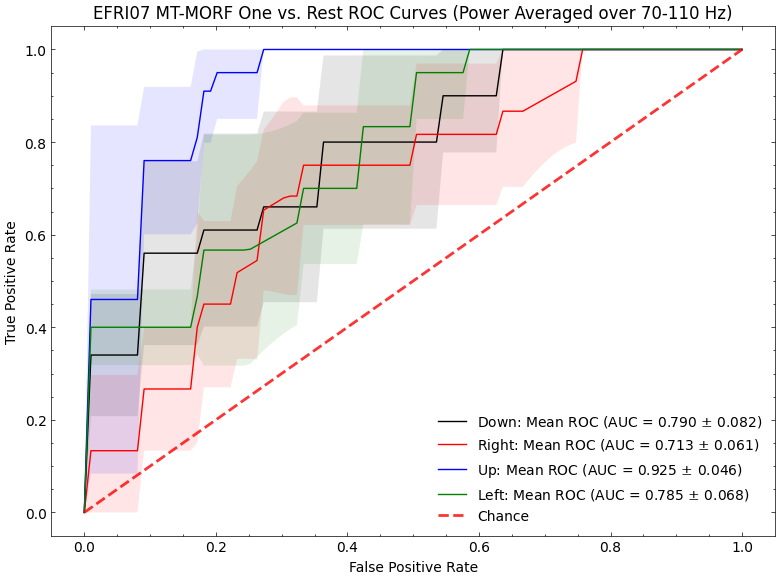

In [18]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_trimmed["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_trimmed["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 70-110 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

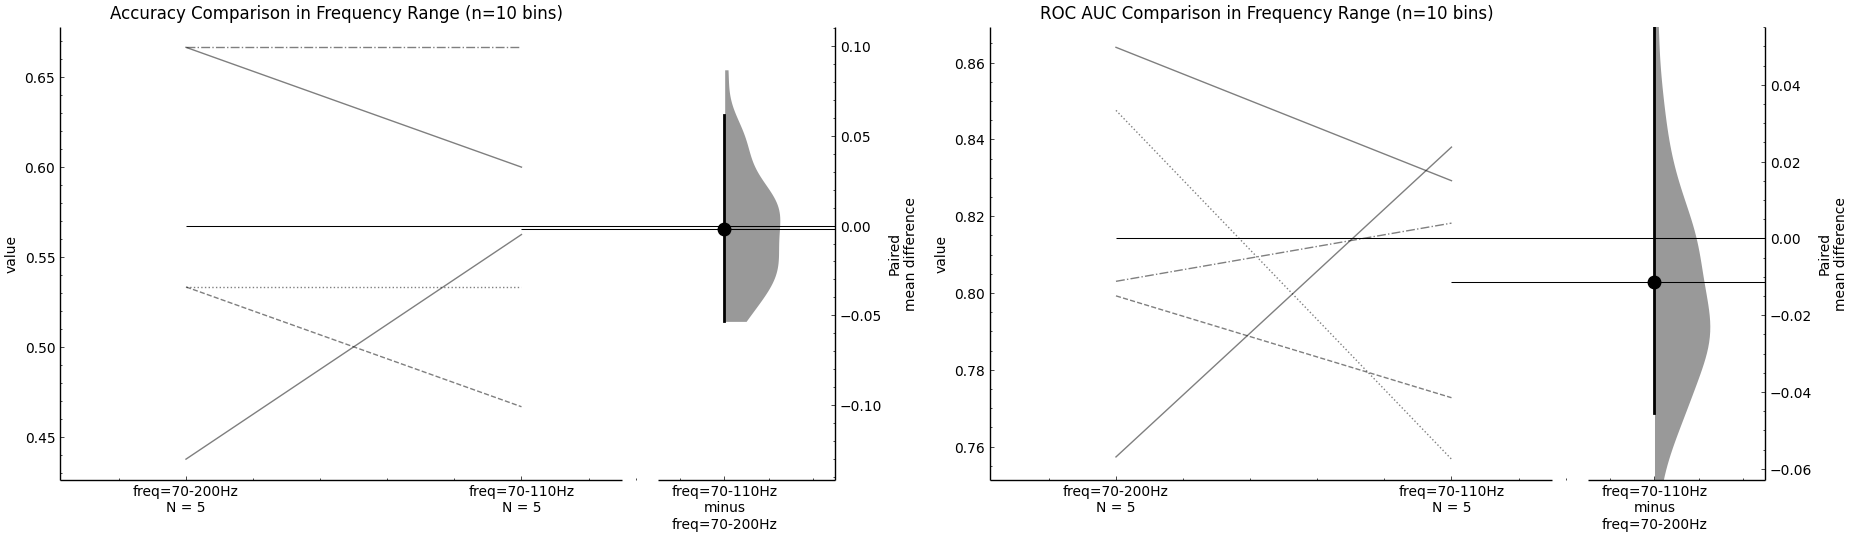

In [19]:
id_col = pd.Series(range(1, n_splits+1))

fig, axs = plt.subplots(ncols=2, figsize=(22,6), dpi=100)
axs = axs.flatten()

## Accuracy comparison
df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_accuracy"],
    "freq=70-110Hz": stratified_kf_scores_trimmed["test_accuracy"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=70-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

my_data.mean_diff.plot(ax=axs[0])

axs[0].set(title="Accuracy Comparison in Frequency Range (n=10 bins)")

## ROC AUC Comparison
df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "freq=70-110Hz": stratified_kf_scores_trimmed["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=70-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

my_data.mean_diff.plot(ax=axs[1])
axs[1].set(title="ROC AUC Comparison in Frequency Range (n=10 bins)");

## 35-110 Hz

In [20]:
nfreqs = 10
freqs = np.logspace(*np.log10([35, 110]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

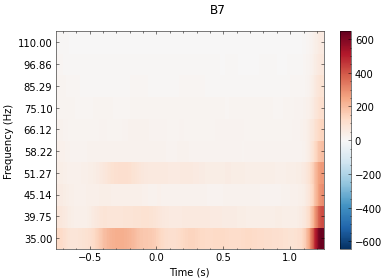

In [21]:
power.average().plot(["B7"]);

In [22]:
hi_gamma = power.data
avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

stratified_kf_scores_trimmed = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_trimmed.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

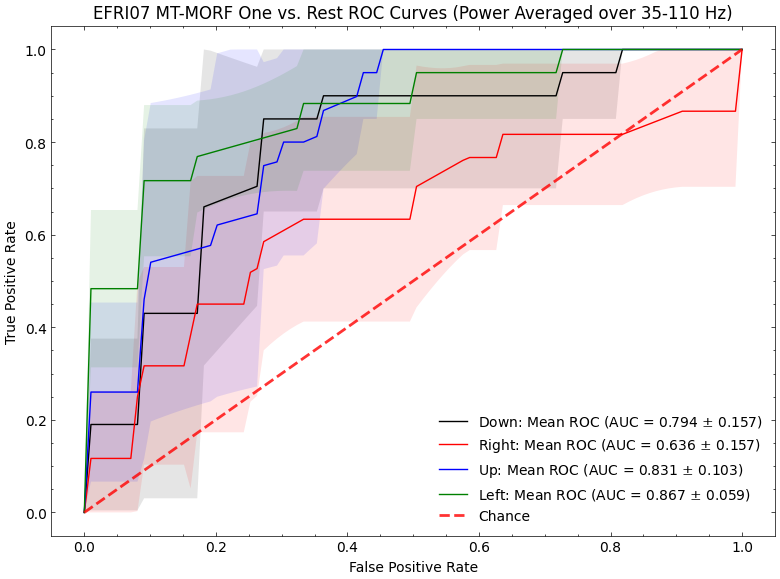

In [23]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_trimmed["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_trimmed["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 35-110 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

In [24]:
id_col = pd.Series(range(1, n_splits+1))

fig, axs = plt.subplots(ncols=2, figsize=(22, 6), dpi=100)

df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_accuracy"],
    "freq=35-110Hz": stratified_kf_scores_trimmed["test_accuracy"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=35-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)


my_data.mean_diff.plot(ax=axs[0])
axs[0].set(title="Accuracy Comparison in Frequency Range (n=10 bins)")

## ROC AUC Comparison
df = pd.DataFrame({
    "ID": id_col,
    "freq=70-200Hz": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "freq=35-110Hz": stratified_kf_scores_trimmed["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("freq=70-200Hz", "freq=35-110Hz"),
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

my_data.mean_diff.plot(ax=axs[1])
axs[1].set(title="ROC AUC Comparison in Frequency Range (n=10 bins)");

## Run on $N \times (C \times F) \times T$ data matrix (70-200 Hz)

In [25]:
nfreqs = 10
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

hi_gamma = power.data

ntrials, nchs, nfreqs, nsteps = hi_gamma.shape

# structured to have all frequencies of one channel in consecutive rows
freq_data = hi_gamma.reshape(ntrials, nchs*nfreqs, nsteps)

times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
freq_data = freq_data[:, :, times]

In [26]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=freq_data.shape[1],
    image_width=freq_data.shape[2],
)

stratified_kf_scores_all_freq = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_all_freq.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr', 'train_roc_auc_ovr', 'train_predict_proba', 'train_preds', 'train_inds', 'train_fpr', 'train_tpr', 'train_fnr', 'train_tnr', 'train_thresholds', 'train_confusion_matrix', 'test_predict_proba', 'test_preds', 'test_inds', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds', 'test_confusion_matrix', 'model_params'])

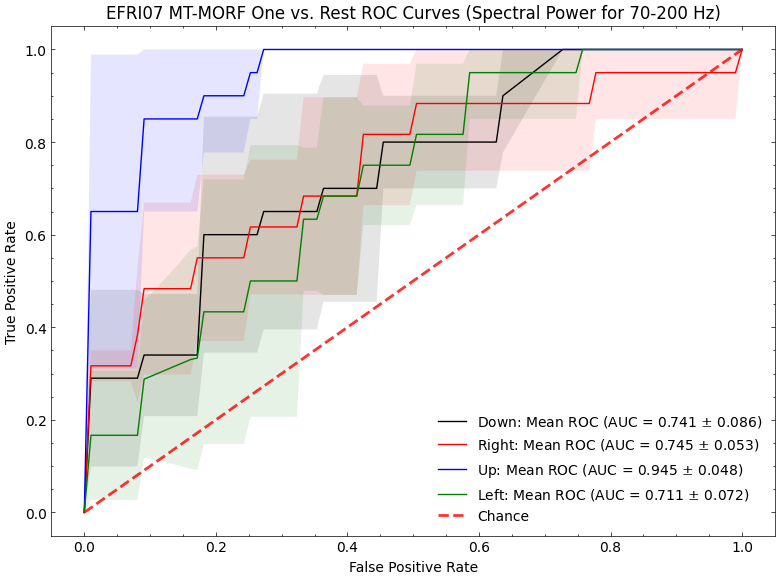

In [27]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_all_freq["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_all_freq["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Spectral Power for 70-200 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

In [28]:
id_col = pd.Series(range(1, n_splits+1))

fig, axs = plt.subplots(ncols=2, figsize=(22, 6), dpi=100)
axs = axs.flatten()

## Accuracy comparison
df = pd.DataFrame({
    "ID": id_col,
    "Averaged": stratified_kf_scores_freq_avg["test_accuracy"],
    "All": stratified_kf_scores_all_freq["test_accuracy"],
})

my_data = dabest.load(df, idx=("Averaged", "All"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)


my_data.mean_diff.plot(ax=axs[0])
axs[0].set(title="Accuracy Comparison between Average and All Frequencies (70-200 Hz)")

id_col = pd.Series(range(1, n_splits+1))

## ROC AUC comparison
df = pd.DataFrame({
    "ID": id_col,
    "Averaged": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "All": stratified_kf_scores_all_freq["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("Averaged", "All"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

my_data.mean_diff.plot(ax=axs[1])
axs[1].set(title="ROC AUC Comparison between Average and All Frequencies (70-200 Hz)");

## Run on $N \times (C \times F) \times T$ data matrix (35-110 Hz)

In [29]:
nfreqs = 10
freqs = np.logspace(*np.log10([35, 110]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

hi_gamma = power.data

ntrials, nchs, nfreqs, nsteps = hi_gamma.shape

# structured to have all frequencies of one channel in consecutive rows
freq_data = hi_gamma.reshape(ntrials, nchs*nfreqs, nsteps)

times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
freq_data = freq_data[:, :, times]

In [ ]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=freq_data.shape[1],
    image_width=freq_data.shape[2],
)

stratified_kf_scores_all_freq_35_110 = cv_fit(mtsmorf, X, y, metrics=metrics, cv=cv, n_jobs=None, return_train_score=True, return_estimator=True)
stratified_kf_scores_all_freq_35_110.keys()

In [ ]:
fig, ax = plt.subplots(dpi=100, figsize=(8, 6))

plot_roc_multiclass_cv(
    stratified_kf_scores_all_freq_35_110["test_predict_proba"],
    X,
    y,
    stratified_kf_scores_all_freq_35_110["test_inds"],
    ax=ax,
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"{subject.upper()} MT-MORF One vs. Rest ROC Curves (Power Averaged over 35-110 Hz)",
)
ax.legend(loc="lower right")
fig.tight_layout();

In [ ]:
## TODO: N x (CxF) x T data matrix
# Compare w/ prev experiments using DABEST
# Run1: nfreqs=10, l_freq=70, h_freq=200
# Run2: nfreqs=30, l_freq=70, h_freq=200
    # then think about what range will work
    # run on other subjects
# run full permutation importance on N x (CxF) x T data matrix
    # see what frequencies are meaningful
    # try ablating channels based on perm importance and rerun mtmorf
    # and do above spectral power comparisons
# overleaf outline - purpose, set of hypotheses + corresp experiments

In [ ]:
id_col = pd.Series(range(1, n_splits+1))

fig, axs = plt.subplots(ncols=2, figsize=(22, 6), dpi=100)
axs = axs.flatten()

## Accuracy comparison
df = pd.DataFrame({
    "ID": id_col,
    "Averaged": stratified_kf_scores_freq_avg["test_accuracy"],
    "All": stratified_kf_scores_all_freq_35_110["test_accuracy"],
})

my_data = dabest.load(df, idx=("Averaged", "All"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)


my_data.mean_diff.plot(ax=axs[0])
axs[0].set(title="Accuracy Comparison between Average (70-200 Hz) and All Frequencies (35-110 Hz)")

## ROC AUC comparison
df = pd.DataFrame({
    "ID": id_col,
    "Averaged": stratified_kf_scores_freq_avg["test_roc_auc_ovr"],
    "All": stratified_kf_scores_all_freq_35_110["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("Averaged", "All"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

my_data.mean_diff.plot(ax=axs[1])
axs[1].set(title="ROC AUC Comparison between Average (70-200 Hz) and All Frequencies (35-110 Hz)");

In [ ]:
id_col = pd.Series(range(1, n_splits+1))

fig, axs = plt.subplots(ncols=2, figsize=(22, 6), dpi=100)
axs = axs.flatten()

## Accuracy comparison
df = pd.DataFrame({
    "ID": id_col,
    "70-200 Hz": stratified_kf_scores_all_freq["test_accuracy"],
    "35-110 Hz": stratified_kf_scores_all_freq_35_110["test_accuracy"],
})

my_data = dabest.load(df, idx=("70-200 Hz", "35-110 Hz"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

my_data.mean_diff.plot(ax=axs[0])
axs[0].set(title="Accuracy Comparison using All Frequencies")

## ROC AUC comparison
df = pd.DataFrame({
    "ID": id_col,
    "70-200 Hz": stratified_kf_scores_all_freq["test_roc_auc_ovr"],
    "35-110 Hz": stratified_kf_scores_all_freq_35_110["test_roc_auc_ovr"],
})

my_data = dabest.load(df, idx=("70-200 Hz", "35-110 Hz"), 
                      id_col="ID", paired=True, resamples=100, 
                      random_seed=rng)

my_data.mean_diff.plot(ax=axs[1])
axs[1].set(title="ROC AUC Comparison using All Frequencies");

In [ ]:
nfreqs = 30
freqs = np.logspace(*np.log10([70, 200]), num=nfreqs)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, average=False,
                   return_itc=False, decim=3, n_jobs=1)

hi_gamma = power.data

ntrials, nchs, nfreqs, nsteps = hi_gamma.shape

# structured to have all frequencies of one channel in consecutive rows
freq_data = hi_gamma.reshape(ntrials, nchs*nfreqs, nsteps)

avg_freq_data = np.mean(hi_gamma, axis=2)

# Trim time window
# times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
# freq_data = freq_data[:, :, times]

times = np.where((power.times >= -0.5) & (power.times <= 1.0))[0]
avg_freq_data = avg_freq_data[:, :, times]

avg_freq_data.shape

In [ ]:
rng = 1

included_trials = np.isin(labels, [0, 1, 2, 3])

# Create X, y data
X = avg_freq_data[included_trials].reshape(np.sum(included_trials), -1)
y = labels[included_trials]

metrics = [
    # 'f1_micro',
    # 'f1_macro',
    'accuracy',
    'roc_auc_ovr',
]

mtsmorf = rerfClassifier(
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

srerf = rerfClassifier(
    projection_matrix="S-RerF",
    max_features="auto",
    n_jobs=-1,
    random_state=rng,
    image_height=avg_freq_data.shape[1],
    image_width=avg_freq_data.shape[2],
)

lr = LogisticRegression(random_state=rng)
rf = RandomForestClassifier(random_state=rng)
dummy = DummyClassifier(strategy='most_frequent', random_state=rng)

clf_scores = dict()
clfs = [
    mtsmorf,
    srerf,
    rf,
    lr,
    dummy,
]

for clf in tqdm(clfs):
    if clf.__class__.__name__ == "rerfClassifier":
        clf_name = clf.get_params()["projection_matrix"]
    elif clf.__class__.__name__ == "DummyClassifier":
        clf_name = clf.strategy
    else:
        clf_name = clf.__class__.__name__

    clf_scores[clf_name] = cv_fit(
        clf,
        X,
        y,
        cv=cv,
        metrics=metrics,
        n_jobs=None,
        return_train_score=True,
        return_estimator=True,
    )

In [ ]:
fig, ax = plt.subplots(dpi=100, figsize=(8,6))

accs = np.array([np.mean(scores["test_accuracy"]) for scores in clf_scores.values()])
acc_std = np.array([np.std(scores["test_accuracy"]) for scores in clf_scores.values()])

ax.errorbar(list(clf_scores.keys()), accs, yerr=acc_std, fmt='o', markersize=8, capsize=15)
ax.axhline(np.mean(clf_scores["MT-MORF"]["test_accuracy"]), lw=1, color='k', ls='--')
ax.set(ylabel="accuracy", title=f"{subject.upper()}: Accuracy of Classifiers (n=30 freq bins, 70-200 Hz)")
fig.tight_layout();